In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary
import xarray as xr
import yaml

import Dataset
import Models
import Loss
from utils import time_func

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Cuda device: {torch.cuda.get_device_name()}")
print(f"Cuda version: {torch.version.cuda}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 2.1.0+cu121
Cuda available: True
Cuda device: NVIDIA A100-SXM4-40GB
Cuda version: 12.1
Torch geometric version: 2.3.1


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
params = yaml.safe_load(open('./config/pipeline.yaml'))

DATA_PATH = params['input_subset_pre_processed']
MESH_PATH = params['input_subset_grid']

DATASET_SIZE = params['dataset_size']

RANDOM_SEED = params['random_seed']
USE_SEED = params['use_seed']

TRAIN_PROP = params['train_prop']
VAL_PROP = params['val_prop']
TEST_PROP = params['test_prop']
TRAIN_VAL_TEST = [TRAIN_PROP, VAL_PROP, TEST_PROP]

TRAIN_BATCH_SIZE = params['train_batch_size']
VAL_BATCH_SIZE = params['val_batch_size']
TEST_BATCH_SIZE = params['test_batch_size']

N_FEATURES = params['n_features']
HID_CHANNELS = params['hid_channels']
N_CLASSES = params['n_classes']

FINAL_ACT = None
if params['final_act'] == "sigmoid":
    FINAL_ACT = torch.sigmoid
elif params['final_act'] == "softmax":
    FINAL_ACT = torch.softmax
elif params['final_act'] == "linear":
    FINAL_ACT = torch.nn.Linear(1, 1)

LOSS_OP = None
if params['loss_op'] == "CE":
    LOSS_OP = torch.nn.CrossEntropyLoss()
elif params['loss_op'] == "WCE":
    class_weights = [params['loss_weight_1'], params['loss_weight_2'], params['loss_weight_3']]
    LOSS_OP = Loss.WeightedCrossEntropyLoss(class_weights, DEVICE)

OPTIMIZER = None
if params['optimizer'] == "Adam":
    OPTIMIZER = torch.optim.Adam

LEARN_RATE = params['learn_rate']

EPOCHS = params['epochs']

PLOT_SHOW = params['plot_show']
PLOT_FOLDER = params['output_images_path']

TIMESTAMP = time_func.start_time()

### Dataset creation with train-val-test split

In [5]:
if not USE_SEED:
    RANDOM_SEED = random.randint(1, 10000)

print(f"Random seed for train-val-test split: {RANDOM_SEED}")

timestamp = time_func.start_time()

train_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, dataset_size=DATASET_SIZE, split='train', proportions=TRAIN_VAL_TEST, random_seed=RANDOM_SEED)
val_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, dataset_size=DATASET_SIZE, split='val', proportions=TRAIN_VAL_TEST, random_seed=RANDOM_SEED)
test_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, dataset_size=DATASET_SIZE, split='test', proportions=TRAIN_VAL_TEST, random_seed=RANDOM_SEED)

time_func.stop_time(timestamp, "Datasets creation")

Random seed for train-val-test split: 3150
    Shape of node feature matrix: torch.Size([757747, 1])
    Shape of graph connectivity in COO format: torch.Size([2, 4537526])
    Shape of edge weights: ()
    Shape of labels: torch.Size([757747])
  ---  Datasets creation  ---  26.597 seconds.


In [6]:
print(train_dataset.len(), val_dataset.len(), test_dataset.len())

1169 146 146


### MinMaxScaling and StandardScaling implementation

In [8]:
'''
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

timestamp = time_func.start_time()

train_set = [item for item in train_dataset]
val_set = [item for item in val_dataset]
test_set = [item for item in test_dataset]

# Using a DataLoader to make .partial_fit() x5 faster than with train_dataset
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)

for batch in train_loader:
    scaler.partial_fit(batch.x)

print(scaler.data_min_, scaler.data_max_)
#print(scaler.mean_, scaler.var_)

for i in range(len(train_set)):
    train_set[i].x = scaler.transform(train_set[i].x)

for i in range(len(val_set)):
    val_set[i].x = scaler.transform(val_set[i].x)

for i in range(len(test_set)):
    test_set[i].x = scaler.transform(test_set[i].x)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

time_func.stop_time(timestamp, "Scaling done!")
'''

In [7]:
'''
train_dataset[0]

timestamp = time_func.start_time()
features_list = [data.x for data in train_dataset]
print(np.shape(features_list))
time_func.stop_time(timestamp, "features in a list!")

timestamp = time_func.start_time()
all_features = torch.cat(features_list, dim=0)
time_func.stop_time(timestamp, "features concatenated!")

all_features.shape
'''

'\ntrain_dataset[0]\n\ntimestamp = time_func.start_time()\nfeatures_list = [data.x for data in train_dataset]\nprint(np.shape(features_list))\ntime_func.stop_time(timestamp, "features in a list!")\n\ntimestamp = time_func.start_time()\nall_features = torch.cat(features_list, dim=0)\ntime_func.stop_time(timestamp, "features concatenated!")\n\nall_features.shape\n'

In [14]:
'''
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)

min_v = torch.tensor(float('inf')).to(DEVICE)
max_v = torch.tensor(-float('inf')).to(DEVICE)

for batch in train_loader:
    batch = batch.to(DEVICE)
    
    batch_x_min = torch.min(batch.x)
    batch_x_max = torch.max(batch.x)

    min_v = torch.min(min_v, batch_x_min)
    max_v = torch.max(max_v, batch_x_max)

min_v, max_v
'''

"\ntrain_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)\n\nmin_v = torch.tensor(float('inf')).to(DEVICE)\nmax_v = torch.tensor(-float('inf')).to(DEVICE)\n\nfor batch in train_loader:\n    batch = batch.to(DEVICE)\n    \n    batch_x_min = torch.min(batch.x)\n    batch_x_max = torch.max(batch.x)\n\n    min_v = torch.min(min_v, batch_x_min)\n    max_v = torch.max(max_v, batch_x_max)\n\nmin_v, max_v\n"

In [15]:
'''
min_v, max_v = float('inf'), -float('inf')
for data in train_dataset:
    min_v = min(min_v, data.x.min())
    max_v = max(max_v, data.x.max())
min_v, max_v
'''

"\nmin_v, max_v = float('inf'), -float('inf')\nfor data in train_dataset:\n    min_v = min(min_v, data.x.min())\n    max_v = max(max_v, data.x.max())\nmin_v, max_v\n"

In [16]:
#features_list = np.asarray(features_list)
#np.min(features_list), np.max(features_list)

In [17]:
'''
global_mean = all_features.mean(dim=0)
global_std = all_features.std(dim=0)
print(f"Mean: {global_mean}\nStd: {global_std}")
'''

'\nglobal_mean = all_features.mean(dim=0)\nglobal_std = all_features.std(dim=0)\nprint(f"Mean: {global_mean}\nStd: {global_std}")\n'

In [18]:
'''
from torch_geometric.transforms import NormalizeFeatures
transform = NormalizeFeatures()

print(train_dataset[0].x)

timestamp = time_func.start_time()

train_dataset = [transform(data) for data in train_dataset]
val_dataset = [transform(data) for data in val_dataset]
test_dataset = [transform(data) for data in test_dataset]

time_func.stop_time(timestamp, "features normalized!")
'''

'\nfrom torch_geometric.transforms import NormalizeFeatures\ntransform = NormalizeFeatures()\n\nprint(train_dataset[0].x)\n\ntimestamp = time_func.start_time()\n\ntrain_dataset = [transform(data) for data in train_dataset]\nval_dataset = [transform(data) for data in val_dataset]\ntest_dataset = [transform(data) for data in test_dataset]\n\ntime_func.stop_time(timestamp, "features normalized!")\n'

In [19]:
'''
features = [data.x for data in train_dataset]
all_features = torch.cat(features, dim=0)
mean = all_features.mean(dim=0)
std = all_features.std(dim=0)
print(f"Mean: {mean}\nStd: {std}")
'''

'\nfeatures = [data.x for data in train_dataset]\nall_features = torch.cat(features, dim=0)\nmean = all_features.mean(dim=0)\nstd = all_features.std(dim=0)\nprint(f"Mean: {mean}\nStd: {std}")\n'

### Testing some hyperparameters and orientation of graph edges

In [20]:
if (TRAIN_PROP+VAL_PROP+TEST_PROP) != 100:
    raise ValueError(f"Sum of train-val-test proportions with value {TRAIN_PROP+VAL_PROP+TEST_PROP} is different from 100")

if FINAL_ACT == None:
    raise ValueError(f"Parameter 'final_act' is invalid with value {params['final_act']}")

if LOSS_OP == None:
    if params['loss_op'] != "Dice":
        raise ValueError(f"Parameter 'loss_op' is invalid with value {params['loss_op']}")

if OPTIMIZER == None:
    raise ValueError(f"Parameter 'optimizer' is invalid with value {params['optimizer']}")

dummy_graph = train_dataset[0]

if dummy_graph.num_features != N_FEATURES:
    raise ValueError(f"Graph num_features is different from parameter N_FEATURES: ({dummy_graph.num_features} != {N_FEATURES})")

if dummy_graph.is_directed():
    raise ValueError("Graph edges are directed!")

### DataLoaders creation

In [21]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

1169 146 146


### Model instantiation

In [22]:
Model = Models.GUNet

model = Model(
    in_channels = N_FEATURES,
    hidden_channels = HID_CHANNELS,
    out_channels = N_CLASSES,
    num_nodes = dummy_graph.num_nodes,   # TODO can put these in Dataset.py
    final_act = FINAL_ACT
).to(DEVICE)

print(model)

GUNet instantiated!
	Middle act: relu
	Final act: softmax
GUNet(
  (unet): GraphUNet(1, 32, 3, depth=3, pool_ratios=[0.002639403389257892, 0.5, 0.5])
)


In [23]:
dummy_graph.to(DEVICE)
print(summary(model, dummy_graph))

+-------------------------------+---------------------------------------------------+---------------------------------------------------------+----------+
| Layer                         | Input Shape                                       | Output Shape                                            | #Param   |
|-------------------------------+---------------------------------------------------+---------------------------------------------------------+----------|
| GUNet                         | [757747, 757747]                                  | [757747, 3]                                             | 5,539    |
| ├─(unet)GraphUNet             | [757747, 1], [2, 4537526]                         | [757747, 3]                                             | 5,539    |
| │    └─(down_convs)ModuleList | --                                                | --                                                      | 3,232    |
| │    │    └─(0)GCNConv        | [757747, 1], [2, 4537526], [4537526]

### Optimizer

In [24]:
OPTIMIZER = OPTIMIZER(model.parameters(), lr=LEARN_RATE)

### Early Stopping

In [25]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = float('inf')
        
    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print(f'EarlyStopper counter is equal to the patience with value {self.counter}, interrupting trainig...')
                return True
        return False

EARLY_STOPPER = EarlyStopper()

### Dice Loss

In [26]:
if params['loss_op'] == "Dice":
    
    timestamp = time_func.start_time()

    tot_counts = [0, 0, 0]
    for batch in train_loader:
        batch = batch.to(DEVICE)
        
        unique, counts = torch.unique(batch.y, return_counts=True)
        
        # TODO - I still don't like this, it just raises an error if something is wrong
        if 0 not in unique:
            raise ValueError("Error: class 0 not present in batch")
        elif 1 not in unique:
            raise ValueError("Error: class 1 not present in batch")
        elif 2 not in unique:
            raise ValueError("Error: class 2 not present in batch")
        else:
            for class_idx in unique:
                tot_counts[class_idx] += counts[class_idx].item()

    time_func.stop_time(timestamp, "Unique counted!")
    
    freq = [c/np.sum(tot_counts) for c in tot_counts]
    freq_inv = [1/f for f in freq]
    class_weights = [f/np.sum(freq_inv) for f in freq_inv]
    print(freq_inv, "- freq_inv")
    print(class_weights, "- class_weights")
    LOSS_OP = Loss.SoftDiceLoss(class_weights)

  ---  Unique counted!  ---  56.565 seconds.
[1.1141916972297854, 19.479133724300116, 19.54981069282359] - freq_inv
[0.0277554721697839, 0.48524195191952624, 0.4870025759106898] - class_weights


### Train function

In [27]:
def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        # zero the parameter gradients
        OPTIMIZER.zero_grad()

        # forward + loss
        pred = model(batch)
        loss = LOSS_OP(pred, batch.y)
        
        total_loss += loss.item() * batch.num_graphs
        
        # backward + optimize
        loss.backward()
        OPTIMIZER.step()

    average_loss = total_loss / len(train_loader.dataset)
    return average_loss

### Evaluation function

In [28]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0

    for batch in loader:
        batch = batch.to(DEVICE)

        # forward + loss
        pred = model(batch)
        loss = LOSS_OP(pred, batch.y)

        total_loss += loss.item() * batch.num_graphs
    
    average_loss = total_loss / len(loader.dataset)
    return average_loss

### Computation time check

In [29]:
time_func.stop_time(TIMESTAMP, "Computation before training finished!")

  ---  Computation before training finished!  ---  495.330 seconds.


In [30]:
'''
from time import time
import multiprocessing as mp

for num_workers in range(2, mp.cpu_count(), 2):
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
        for i, data in enumerate(val_loader, 0):
            pass
    end = time()
    print("Finish with: {} second, num_workers={}".format(end - start, num_workers))
'''

'\nfrom time import time\nimport multiprocessing as mp\n\nfor num_workers in range(2, mp.cpu_count(), 2):\n    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)\n    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)\n\n    start = time()\n    for epoch in range(1, 3):\n        for i, data in enumerate(train_loader, 0):\n            pass\n        for i, data in enumerate(val_loader, 0):\n            pass\n    end = time()\n    print("Finish with: {} second, num_workers={}".format(end - start, num_workers))\n'

### Epoch training, validation and testing

In [31]:
timestamp = time_func.start_time()

train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    t_loss = train()
    v_loss = evaluate(val_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f'Epoch: {epoch+1:03d}, Train running loss: {t_loss:.4f}, Val running loss: {v_loss:.4f}')
    
    if EARLY_STOPPER.early_stop(v_loss):
        break

time_func.stop_time(timestamp, "Training Complete!")

metric = evaluate(test_loader)
print(f'Metric for test: {metric:.4f}')

Epoch: 001, Train running loss: 0.8767, Val running loss: 0.8335
Epoch: 002, Train running loss: 0.8145, Val running loss: 0.7556
Epoch: 003, Train running loss: 0.7856, Val running loss: 0.7324
Epoch: 004, Train running loss: 0.7763, Val running loss: 0.7240
Epoch: 005, Train running loss: 0.7717, Val running loss: 0.7220
Epoch: 006, Train running loss: 0.7691, Val running loss: 0.7197
Epoch: 007, Train running loss: 0.7673, Val running loss: 0.7193
Epoch: 008, Train running loss: 0.7658, Val running loss: 0.7190
Epoch: 009, Train running loss: 0.7648, Val running loss: 0.7185
Epoch: 010, Train running loss: 0.7637, Val running loss: 0.7175
Epoch: 011, Train running loss: 0.7630, Val running loss: 0.7187
Epoch: 012, Train running loss: 0.7623, Val running loss: 0.7176
Epoch: 013, Train running loss: 0.7614, Val running loss: 0.7169
Epoch: 014, Train running loss: 0.7609, Val running loss: 0.7179
Epoch: 015, Train running loss: 0.7602, Val running loss: 0.7184
Epoch: 016, Train running

### Comparison plot for train/validation loss

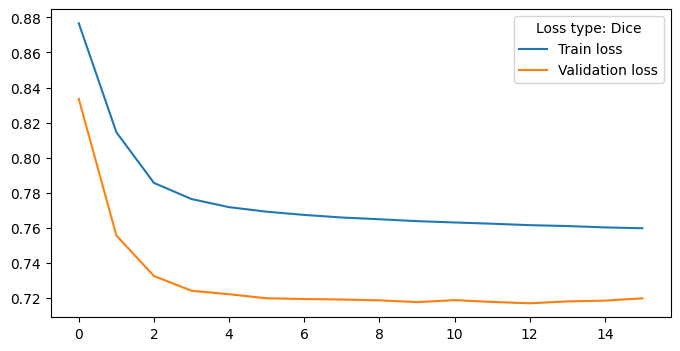

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(title="Loss type: " + params['loss_op'])

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER+"/train_val_losses_demo.png")
    plt.close()

In [33]:
### Hypothesis: the network can train on the 1/8 mesh and test the original sized one
'''
timestamp = time_func.start_time()
DEVICE=torch.device('cpu')
model = model.to(DEVICE)


DATA_PATH = "/work/ab0995/b382485/eddy_data/original_roi/pre_proc_train/big_test/"
MESH_PATH = "/work/ab0995/b382485/eddy_data/original_roi/pre_proc_train/big_test/subset_mesh.nc"
o_train_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, dataset_size=100, split='train', proportions=TRAIN_VAL_TEST, random_seed=random_seed)
o_train_loader = DataLoader(o_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)

model.eval()
with torch.no_grad():
    batch = next(iter(o_train_loader))
    batch = batch.to(DEVICE)
    pred = model(batch)

mesh = xr.open_dataset(MESH_PATH)
mesh_lon = mesh.lon[mesh.nodes].values
mesh_lat = mesh.lat[mesh.nodes].values

this_target = batch.y[:mesh.dims['nodes_subset']]
_, this_pred = torch.max(pred[:mesh.dims['nodes_subset']], dim=1)


fig, axes = plt.subplots(2, 1, figsize=(10, 10))

im_target = axes[0].scatter(mesh_lon, mesh_lat, c=this_target, s=1)
axes[0].set_title('Batch target')

im_pred = axes[1].scatter(mesh_lon, mesh_lat, c=this_pred, s=1)
axes[1].set_title('Batch prediction')

plt.show()


### Test the 1/8 predictions

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    batch = batch.to(DEVICE)
    pred = model(batch[0])
pred.shape


# TODO: this has to be customized every time -> find a way to associate the graph with the mesh number, may save it during Dataset.process()
this_mesh = MESH_PATH[:70]+'subset_mesh_1.nc'
this_mesh


mesh = xr.open_dataset(this_mesh)
mesh_lon = mesh.lon[mesh.nodes].values
mesh_lat = mesh.lat[mesh.nodes].values

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

this_target = batch[0].y
_, this_pred = torch.max(pred, dim=1)

im_target = axes[0].scatter(mesh_lon, mesh_lat, c=this_target, s=1)
axes[0].set_title('Batch target')

im_pred = axes[1].scatter(mesh_lon, mesh_lat, c=this_pred, s=1)
axes[1].set_title('Batch prediction')

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER + "/pred_vs_ground_demo.png")
    plt.close()

time_func.stop_time(timestamp, "pred_vs_ground plot created!")
'''

'\ntimestamp = time_func.start_time()\nDEVICE=torch.device(\'cpu\')\nmodel = model.to(DEVICE)\n\n\nDATA_PATH = "/work/ab0995/b382485/eddy_data/original_roi/pre_proc_train/big_test/"\nMESH_PATH = "/work/ab0995/b382485/eddy_data/original_roi/pre_proc_train/big_test/subset_mesh.nc"\no_train_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, dataset_size=100, split=\'train\', proportions=TRAIN_VAL_TEST, random_seed=random_seed)\no_train_loader = DataLoader(o_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)\n\nmodel.eval()\nwith torch.no_grad():\n    batch = next(iter(o_train_loader))\n    batch = batch.to(DEVICE)\n    pred = model(batch)\n\nmesh = xr.open_dataset(MESH_PATH)\nmesh_lon = mesh.lon[mesh.nodes].values\nmesh_lat = mesh.lat[mesh.nodes].values\n\nthis_target = batch.y[:mesh.dims[\'nodes_subset\']]\n_, this_pred = torch.max(pred[:mesh.dims[\'nodes_subset\']], dim=1)\n\n\nfig, axes = plt.subplots(2, 1, figsize=(10, 10))\n\nim_

### Graphical comparison model prediction/ground truth

In [34]:
timestamp = time_func.start_time()
DEVICE=torch.device('cpu')
model = model.to(DEVICE)

In [35]:
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    batch = batch.to(DEVICE)
    pred = model(batch)

/home/b/b382485/miniconda3/envs/eddy-tracking-new/lib/python3.11/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  C = torch.sparse.mm(A, B)


In [36]:
mesh = xr.open_dataset(MESH_PATH)
mesh_lon = mesh.lon[mesh.nodes].values
mesh_lat = mesh.lat[mesh.nodes].values

In [37]:
sample_id = 0
start = mesh.dims['nodes_subset'] * sample_id
end = mesh.dims['nodes_subset'] * (sample_id+1)
batch_target = batch.y[start:end]
batch_feature = batch.x[start:end]
_, batch_pred = torch.max(pred[start:end], dim=1)

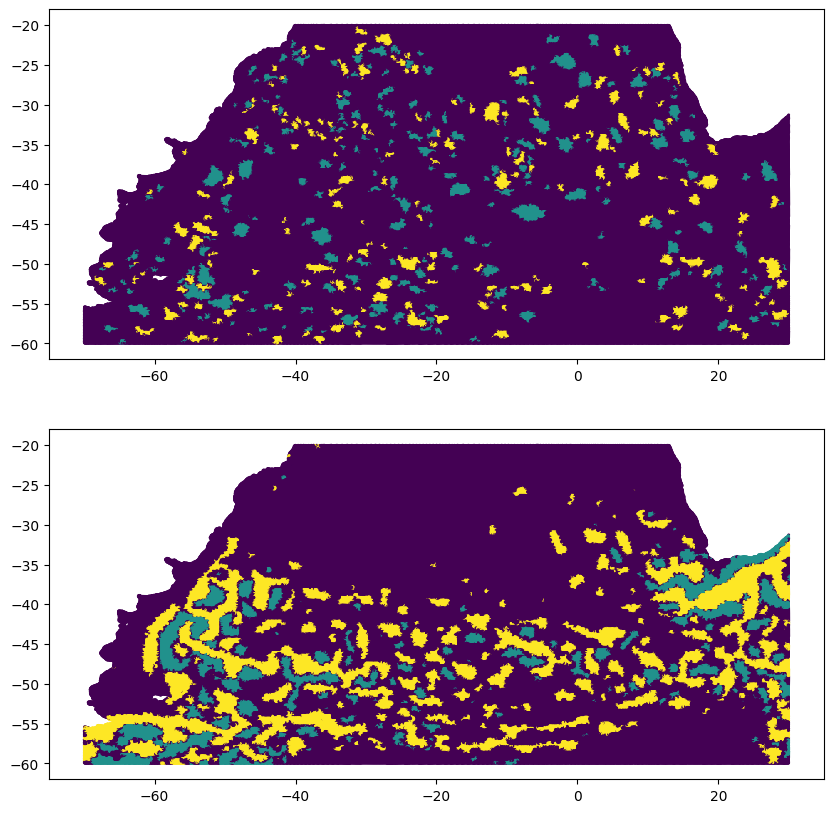

  ---  pred_vs_ground plot created!  ---  77.935 seconds.


In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

im_target = axes[0].scatter(mesh_lon, mesh_lat, c=batch_target, s=1)#, alpha=0.05)
#im_pred = axes[0].scatter(mesh_lon, mesh_lat, c=batch_pred, s=1)#, alpha=0.05)
#axes[0].set_title('Batch target')

#im_feature = axes[1].scatter(mesh_lon, mesh_lat, c=batch_feature, s=1, cmap=cm.seismic, vmin=-.7, vmax=.7)#, alpha=0.05)
im_pred = axes[1].scatter(mesh_lon, mesh_lat, c=batch_pred, s=1)
#axes[1].set_title('Batch prediction')

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER + "/pred_vs_ground_demo.png")
    plt.close()

time_func.stop_time(timestamp, "pred_vs_ground plot created!")

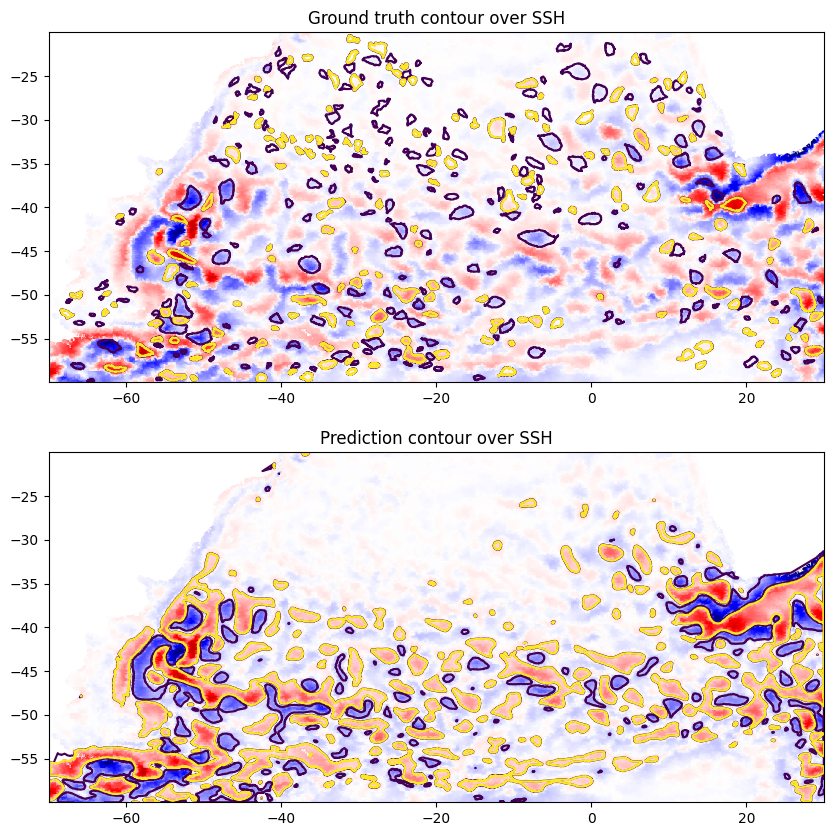

  ---  pred_vs_ground plot created!  ---  102.072 seconds.


In [39]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

im_feature = axes[0].scatter(mesh_lon, mesh_lat, c=batch_feature, s=1, cmap=cm.seismic, vmin=-.7, vmax=.7)
axes[0].tricontour(mesh_lon, mesh_lat, batch_target, [1,2])
axes[0].set_title("Ground truth contour over SSH")

im_feature = axes[1].scatter(mesh_lon, mesh_lat, c=batch_feature, s=1, cmap=cm.seismic, vmin=-.7, vmax=.7)
axes[1].tricontour(mesh_lon, mesh_lat, batch_pred, [1,2])
axes[1].set_title("Prediction contour over SSH")

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER + "/pred_vs_ground_demo.png")
    plt.close()

time_func.stop_time(timestamp, "pred_vs_ground plot created!")

### Accuracy calculation

In [40]:
# Running it on cuda is a huge improvement
DEVICE=torch.device('cuda')
model = model.to(DEVICE)

In [41]:
timestamp = time_func.start_time()

model.eval()
with torch.no_grad():
    tot_background = 0
    correct_pred = 0
    tot_pred = len(test_loader.dataset)*dummy_graph.num_nodes

    for batch in test_loader:
        batch = batch.to(DEVICE)

        pred = model(batch)

        _, indices = torch.max(pred, dim=1)

        tot_background += (batch.y == 0).sum().item()

        # This works because the values in the indices correspond to the values in batch.y
        correct_pred += (indices == batch.y).sum().item()

    print(f"Total background cells:\t{tot_background}")
    print(f"Correct predictions:\t{correct_pred}")
    print(f"Total predictions:\t{tot_pred}")
    print(f"Graph U-Net accuracy:\t{correct_pred/tot_pred*100:.2f}%")

time_func.stop_time(timestamp, "Accuracy calculated!")

Total background cells:	99272720
Correct predictions:	81322573
Total predictions:	110631062
Graph U-Net accuracy:	73.51%
  ---  Accuracy calculated!  ---  15.316 seconds.
